In [1]:
#What exactly we are building?
#A model that learns to compress and reconstruct images.
#A generator that can create digits it’s never seen before.
#A 2D latent space you can navigate like a map of digits!

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the MNIST handwritten digits dataset
transform = transforms.ToTensor()  # Convert images to PyTorch tensors
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)  # Load in mini-batches


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 3482940.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 264764.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2644623.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 255252.68it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Define the Variational Autoencoder model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=2):
        """
        input_dim: total pixels in image (28x28 = 784)
        hidden_dim: size of intermediate hidden layer
        latent_dim: size of compressed representation (2D for visualization)
        """
        super(VAE, self).__init__()

        # ---- ENCODER ----
        # Map input image to hidden features
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Learn the mean of the latent space distribution
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        # Learn the log variance of the latent space distribution
        self.fc22 = nn.Linear(hidden_dim, latent_dim)

        # ---- DECODER ----
        # Map latent space back to hidden layer
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # Map to original image size with pixel values between 0 and 1
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        """Encodes input into a mean and log-variance vector"""
        h = F.relu(self.fc1(x))             # Hidden layer with ReLU
        return self.fc21(h), self.fc22(h)   # Return mean and log variance

    def reparameterize(self, mu, logvar):
        """
        Sample from N(mu, var) using the reparameterization trick:
        z = mu + std * epsilon, where epsilon ~ N(0, 1)
        """
        std = torch.exp(0.5 * logvar)       # Convert log variance to standard deviation
        eps = torch.randn_like(std)         # Random normal noise
        return mu + eps * std               # Sample from the learned distribution

    def decode(self, z):
        """Decodes latent vector back to image"""
        h = F.relu(self.fc3(z))             # Hidden layer
        return torch.sigmoid(self.fc4(h))   # Output pixel values in range (0,1)

    def forward(self, x):
        """Defines the full VAE pipeline"""
        mu, logvar = self.encode(x.view(-1, 784))      # Flatten image and encode
        z = self.reparameterize(mu, logvar)            # Sample from latent space
        return self.decode(z), mu, logvar              # Reconstruct image


In [6]:
# VAE loss: combination of reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar):
    """
    recon_x: reconstructed image
    x: original image
    mu, logvar: mean and log variance of latent distribution
    """
    # How close is the reconstruction to the original?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # How far is the learned distribution from a normal Gaussian? #KL Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD  # Total loss

In [7]:
# Initialize model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [8]:
# ---- TRAINING LOOP ----
num_epochs = 15
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)                  # Move data to device
        optimizer.zero_grad()                   # Reset gradients
        recon_batch, mu, logvar = model(data)   # Forward pass
        loss = vae_loss(recon_batch, data, mu, logvar)  # Compute loss
        loss.backward()                         # Backpropagation
        train_loss += loss.item()               # Track total loss
        optimizer.step()                        # Update weights

    # Print loss after each epoch
    print(f"Epoch {epoch+1}, Average Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Average Loss: 195.5378
Epoch 2, Average Loss: 169.9133
Epoch 3, Average Loss: 165.4593
Epoch 4, Average Loss: 163.0265
Epoch 5, Average Loss: 161.1743
Epoch 6, Average Loss: 159.6908
Epoch 7, Average Loss: 158.3886
Epoch 8, Average Loss: 157.3498
Epoch 9, Average Loss: 156.4802
Epoch 10, Average Loss: 155.7620
Epoch 11, Average Loss: 155.1439
Epoch 12, Average Loss: 154.6315
Epoch 13, Average Loss: 154.1675
Epoch 14, Average Loss: 153.7997
Epoch 15, Average Loss: 153.3676


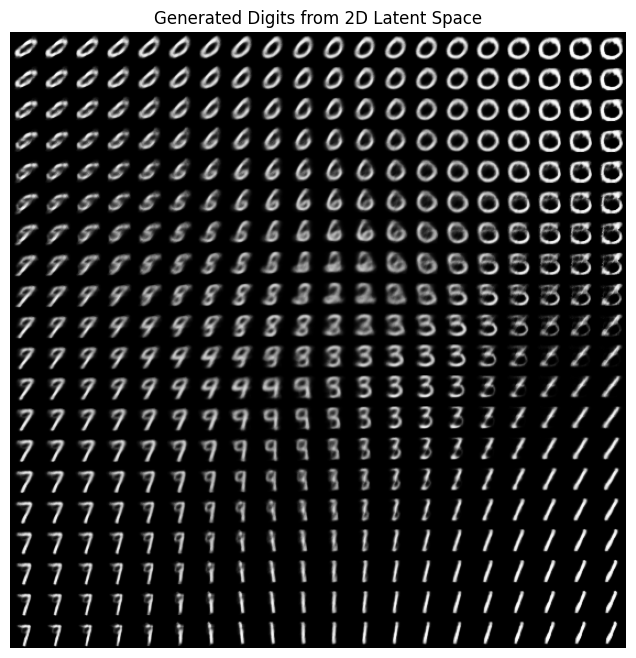

In [9]:
# Visualize what the VAE has learned by decoding points in the 2D latent space
model.eval()
with torch.no_grad():
    n = 20  # number of digits to display in each row and column
    digit_size = 28
    figure = torch.zeros(digit_size * n, digit_size * n)

    # Coordinates will range from -3 to 3 in the latent space
    grid_x = torch.linspace(-3, 3, n)
    grid_y = torch.linspace(-3, 3, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z = torch.tensor([[xi, yi]]).to(device)
            sample = model.decode(z).cpu().view(28, 28)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = sample

# Show the digit grid
plt.figure(figsize=(8, 8))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.title("Generated Digits from 2D Latent Space")
plt.show()
